## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
print(df.head())  # print head of data frame with help of head function
#print(df.columns)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

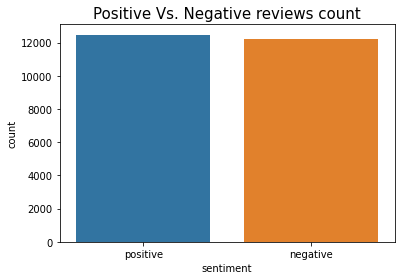

In [4]:
plt.figure(figsize = None)
sns.countplot(x='sentiment',data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df.loc[df['sentiment'] == 'positive']
df_minority = df.loc[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
print(df_upsampled[df_upsampled['sentiment'] == 'negative'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print(df_upsampled[df_upsampled['sentiment'] == 'positive'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train.iloc[:,0], positive_data_points_train.iloc[:,0]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train.iloc[:,1], positive_data_points_train.iloc[:,1]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test.iloc[:,0], positive_data_points_test.iloc[:,0]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test.iloc[:,1], positive_data_points_test.iloc[:,1]])

In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
print(y_train.value_counts())

negative    10000
positive    10000
Name: sentiment, dtype: int64


### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
print(y_test.value_counts())

negative    2474
positive    2474
Name: sentiment, dtype: int64


### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review = review.lower()
    stemmer = PorterStemmer()
    lemmer = WordNetLemmatizer()
    stops = stopwords.words('english')
    review_tokenized = word_tokenize(review)
    review_stemmed = []
    review_lemmed = []
    for word in review_tokenized:
        if word.isalpha() and word != 'br' and word not in stops:
            #review_stemmed.append(stemmer.stem(word))
            review_lemmed.append(lemmer.lemmatize(word))
    review_cleaned = review_lemmed
    return review_cleaned

#PERFORMED LEMMATIZATION, IT WORKED BETTER

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
#I DID NOT USE THIS BELOW, IT LITERALLY SAVES NO TIME OR EFFORT, NOR DOES IT ENHANCE READABILITY, THIS IS A POINTLESS FUNCTION
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    return frequency[(word,label)]

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

#added 0:0 and 1:1 so that I could run this cell multiple times without it screwing up, who omitted these to begin with?
output_map = {'positive': 0, 'negative': 1, 0: 0, 1: 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
## Ensuring that there are equal number of classes on the training data. 
print(y_train.value_counts())

1    10000
0    10000
Name: sentiment, dtype: int64


In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'Mr Perlman gives a standout performance (as usual). Sadly, he has to struggle with an underwritten script and some nonsensical set pieces.<br /><br />Larsen is in "Die Hard" mode complete with singlet and bulging muscles, I\'m sure he could do better but seems satisfied to grimace and snarl through his part.<br /><br />The lovely Erika is very decorative (even though fully clothed!) and shows some signs of "getting" acting at last.<br /><br />SFX are mainly poor CGI and steals from other movies.<br /><br />The shootouts are pitiful - worthy of the A-Team<br /><br />Not even worth seeing for Perlman - AVOID'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

['mr', 'perlman', 'give', 'standout', 'performance', 'usual', 'sadly', 'struggle', 'underwritten', 'script', 'nonsensical', 'set', 'larsen', 'die', 'hard', 'mode', 'complete', 'singlet', 'bulging', 'muscle', 'sure', 'could', 'better', 'seems', 'satisfied', 'grimace', 'snarl', 'lovely', 'erika', 'decorative', 'even', 'though', 'fully', 'clothed', 'show', 'sign', 'getting', 'acting', 'sfx', 'mainly', 'poor', 'cgi', 'steal', 'shootout', 'pitiful', 'worthy', 'even', 'worth', 'seeing', 'perlman', 'avoid']


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        #removed the split from the lower line, instead opting to let clean_review just return a lisr
        split_review = clean_review(review)
        for word in split_review:
            # Your code here
            #check if key exists
            if (word,label) in output_occurrence:
                #if key exists, increment its value
                output_occurrence[(word,label)] += 1
            else:
                #if key does not exist, create it and increment its value
                output_occurrence[(word,label)] = 1
            
            
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('mr', 1): 157,
 ('perlman', 1): 27,
 ('give', 1): 1901,
 ('standout', 1): 13,
 ('performance', 1): 1225,
 ('usual', 1): 325,
 ('sadly', 1): 279,
 ('struggle', 1): 123,
 ('underwritten', 1): 22,
 ('script', 1): 1712,
 ('nonsensical', 1): 36,
 ('set', 1): 1192,
 ('larsen', 1): 2,
 ('die', 1): 330,
 ('hard', 1): 981,
 ('mode', 1): 27,
 ('complete', 1): 454,
 ('singlet', 1): 2,
 ('bulging', 1): 13,
 ('muscle', 1): 37,
 ('sure', 1): 1081,
 ('could', 1): 4562,
 ('better', 1): 2587,
 ('seems', 1): 1598,
 ('satisfied', 1): 25,
 ('grimace', 1): 16,
 ('snarl', 1): 8,
 ('lovely', 1): 142,
 ('erika', 1): 51,
 ('decorative', 1): 2,
 ('even', 1): 6126,
 ('though', 1): 1646,
 ('fully', 1): 115,
 ('clothed', 1): 10,
 ('show', 1): 2973,
 ('sign', 1): 141,
 ('getting', 1): 724,
 ('acting', 1): 3212,
 ('sfx', 1): 17,
 ('mainly', 1): 154,
 ('poor', 1): 1172,
 ('cgi', 1): 173,
 ('steal', 1): 182,
 ('shootout', 1): 17,
 ('pitiful', 1): 52,
 ('worthy', 1): 100,
 ('worth', 1): 893,
 ('seeing', 1): 773,
 ('a

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for key in freqs:
        if key[0] not in vocab:
            vocab.append(key[0])
            
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (zero)
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = train_x.shape[0]
    
    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y == 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(train_y == 1)

    # Calculate logprior
    logprior = math.log(neg_num_docs/pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freq_neg = 0
        if (word,0) in freqs.keys():
            freq_pos = freqs[(word,0)] 
        if (word,1) in freqs.keys():
            freq_neg = freqs[(word,1)] 

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(num_pos + V)
        p_w_neg = (freq_neg + 1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = math.log(p_w_neg/p_w_pos)


    return logprior, loglikelihood

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
55756


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [23]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    if total_prob > 0:
        return 1
    else:
        return 0

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [25]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        pred = naive_bayes_predict(review, logprior, loglikelihood)
        # if the prediction is > 0
        if pred == 1:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = 0
    for i in range(len(y_hats)):
        error += abs(y_hats[i]-test_y.iloc[i])
    error = error/len(y_hats)

    accuracy = 1-error


    return accuracy

In [26]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [27]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [28]:
#split data according to random seed, this assumes upsampling has already occurred
def randomSplitData(df, seed, threshold):
    #this line shuffles the data "randomly" according to the seed
    data = df.sample(frac = 1, random_state = seed).reset_index(drop=True)
    rows,cols = data.shape
    
    #then we proceed as we did above, pulling out 80% of the rows, evenly split between positive and negative,
    #into the training set, and putting the rest in the test set.
    negative_data_points_train = data[data['sentiment'] == 'negative'].iloc[:int(threshold*rows/2)]
    positive_data_points_train = data[data['sentiment'] == 'positive'].iloc[:int(threshold*rows/2)]
    
    negative_data_points_test = data[data['sentiment'] == 'negative'].iloc[int(threshold*rows/2):]
    positive_data_points_test = data[data['sentiment'] == 'positive'].iloc[int(threshold*rows/2):]
    
    X_train = pd.concat([negative_data_points_train.iloc[:,0], positive_data_points_train.iloc[:,0]])
    y_train = pd.concat([negative_data_points_train.iloc[:,1], positive_data_points_train.iloc[:,1]])

    X_test = pd.concat([negative_data_points_test.iloc[:,0], positive_data_points_test.iloc[:,0]])
    y_test = pd.concat([negative_data_points_test.iloc[:,1], positive_data_points_test.iloc[:,1]])
    
    #one step to convert strings to numbers
    output_map = {'positive': 0, 'negative': 1, 0: 0, 1: 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)
    
    return X_train, y_train, X_test, y_test

seed = 100 #chosen by user
threshold = 0.8 #80% to the training set, 20% to the test set
X_train, y_train, X_test, y_test = randomSplitData(df_upsampled, seed, threshold)
#run review_counter on training set to get freqs
frequencies = review_counter({}, X_train, y_train)

#train_naive_bayes on training set
logp, logl = train_naive_bayes(frequencies, X_train, y_train)

#test_naive_bayes on test set
result = test_naive_bayes(X_test, y_test, logp, logl)
print(result)

0.8809619238476953


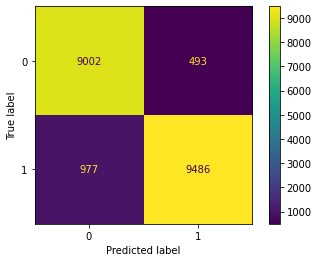

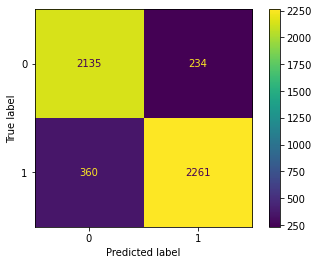

In [29]:
#THIS CELL MAY TAKE A LITTLE WHILE TO RUN
#make confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
def test_naive_bayes_confusion(test_x, test_y, logprior, loglikelihood):
    #this function is just like the one in Q6 except it outputs the comparison of predictions vs true labels
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        pred = naive_bayes_predict(review, logprior, loglikelihood)
        # if the prediction is > 0
        if pred == 1:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    return y_hats


#create confusion matrix from training set
preds = test_naive_bayes_confusion(X_train, y_train, logp, logl)
ConfusionMatrixDisplay.from_predictions(preds, y_train.to_list())
#create confusion matrix from test set
preds2 = test_naive_bayes_confusion(X_test, y_train, logp, logl)
ConfusionMatrixDisplay.from_predictions(preds2, y_test.to_list())
plt.show()

In [62]:
#find 1 false positive case: THIS WAS FOUND WITH SEED 100
falsePositiveIndex = -1
for i in range(len(preds2)):
    ys = y_test.to_list()
    if preds2[i] == 0 and ys[i] == 1:
        falsePositiveIndex = i
        break
        
#match to review, also find loglikelihood values of tokens after cleaning
fp_review = X_test.iloc[falsePositiveIndex]
fp_review_cleaned = clean_review(fp_review)
print(fp_review)
for i in range(len(fp_review_cleaned)):
    if fp_review_cleaned[i] in logl.keys():
        print(fp_review_cleaned[i])
        print(logl[fp_review_cleaned[i]])
    else:
        print(fp_review_cleaned[i])
        print(0)



Watching TRUTH ABOUT LOVE (is this a double entendre about the star?) is like plugging in white noise or manufactured water sounds to help you sleep - you put it in the DVD slot because there is nothing else left on the store shelves and you are in need of distraction after a hectic day. And it works for that for that purpose: being a British romantic comedy it is a bit more.<br /><br />The story is a rather simple one about a wife Alice (Jennifer Love Hewitt) married to an increasingly distant husband Sam (Jimi Mistry) who has put their love life on hold due to the burdens of his busy law practice. His partner Archie (Dougray Scott) is fond of both Sam and Alice, but has a longtime attraction to Alice that goes beyond friendship. Alice pals with her sister Felicity (Kate Miles), a free love advocate, who encourages Alice to have affairs. On Valentine's Day, after a drinking binge with her sister, Alice mails a card to Sam signed 'Anonymous' as a test to see if Sam responds, testing hi

In [31]:
#find 1 false negative case, THIS WAS FOUND WITH SEED 100
falseNegativeIndex = -1
for i in range(len(preds2)):
    ys = y_test.to_list()
    if preds2[i] == 1 and ys[i] == 0:
        falseNegativeIndex = i
        break
        
#match to review, also find loglikelihood values of tokens after cleaning
fn_review = X_test.iloc[falseNegativeIndex]
fn_review_cleaned = clean_review(fn_review)
print(fn_review)
for i in range(len(fn_review_cleaned)):
    print(fn_review_cleaned[i])
    print(logl[fn_review_cleaned[i]])

SPOILER NOTHING BUT SPOILER<br /><br />I have to add my name to the list of folks who feel that the other viewers just don't get it. But no one has even mentioned the "s" word so far as I have seen.<br /><br />While I agree that the kid died I think we can be more specific: he committed suicide. He races down the slope in an old wagon, shoots off the cliff and..."flies away". Maybe the whole account of the form of death is allegory or maybe he does commit suicide in a wagon as laid out. In either case, he "flies away" (c'mon, not that tough a metaphor).<br /><br />Maybe I just have a thing for Tom Hanks, but I was ok with the narration. Besides he is raising $ for the WW2 memorial and you gotta love him for that.<br /><br />Oh yeah, I loved the movie and found it incredibly moving.
spoiler
0.357115019682452
nothing
0.9036304928422207
spoiler
0.357115019682452
add
-0.12837760234084444
name
0.33433570529215423
list
0.29703785399394195
folk
0.08798653970671039
feel
-0.07385789646994895
vi

False Positives and False Negatives:
    
    The issue with Naive Bayes is that it judges words without any regard to context. Both false positives and false negatives are feasible because the final judgment derives from a summation of the log-values given to the individual words. But while a word may be given a positively associated value (i.e. -0.23...), that same word could still be used in a negative review. Enough of these and you will overwhelm the contributions of other words and tilt result in the wrong direction. Some examples from above include:
    In the false positive case, we have 'entendre' at -1.08, 'inscribed' at -1.08, and 'radish' also at -1.08. None of these really jump out as adding a positive vibe to anything (unless people really love radishes), yet they strongly sway the prediction in the positive direction, counteracting strong negative words like 'pathetic' at 1.86 and 'terrible' at 1.95. Indeed one of those 'positive' words is just used in a joke and the other two are used for summary. While it's possible that jokes and summaries are more strongly associated with positive reviews, it's also possible that's just a consequence of the limited data or the model's shortcomings. In this particular case, while there are strongly negative words, the seemingly arbitrary values forced on otherwise neutral-seeming words drags the review prediction in the wrong direction. 
    In the false negative case, we see a similar thing but reversed. Despite positive words like 'loved' at -1.18 and the wierdly positive 'wagon's at -1.47, the review is dragged in the negative direction by a whole lot of innocuous but slightly negatively valued words like 'list' at 0.29 and 'maybe' at 0.43. This particular review seems to have suffered largely because the reviewer is addressing other reviewers 'not getting it' and takes a positive spin on a child's suicide. 


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

In [61]:
#Q9.1
def train_naive_bayes_no_smoothing(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for key in freqs:
        if key[0] not in vocab:
            vocab.append(key[0])
            
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (zero)
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents, BY DOCUMENTS I ASSUME YOU MEAN REVIEWS
    num_doc = train_x.shape[0]
    
    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y == 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(train_y == 1)

    # Calculate logprior
    logprior = math.log(neg_num_docs/pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freq_neg = 0
        if (word,0) in freqs.keys():
            freq_pos = freqs[(word,0)] 
        if (word,1) in freqs.keys():
            freq_neg = freqs[(word,1)] 

        # calculate the probability that each word is positive, and negative, NOT SMOOTHED
        alpha = 1
        p_w_pos = (freq_pos + alpha*1)/(num_pos + alpha*V)
        p_w_neg = (freq_neg + alpha*1)/(num_neg + alpha*V)

        # calculate the log likelihood of the word
        if p_w_pos == 0:
            loglikelihood[word] = 0
        else:
            if p_w_neg == 0:
                #LOG OF 0 IS UNDEFINED, so we set the loglikelihood to 0
                loglikelihood[word] = 0
            else:
                loglikelihood[word] = math.log(p_w_neg/p_w_pos)

    return logprior, loglikelihood

NSlogp, NSlogl = train_naive_bayes_no_smoothing(frequencies, X_train, y_train)
print(test_naive_bayes(X_test, y_test, NSlogp, NSlogl))

0.8809619238476953


1. In my trials, there was a small decrease in accuracy from ~88% to ~86% when removing the additive smoothing, but this isn't particularly relevant to the reason why we have additive smoothing. In the case of Naive Bayes, there may be instances where a word and a label do not appear together, which would result in probabilities of value 0. The code additions required above shows what it takes to adjust to an 'alpha' of 0. So additive smoothing is really used here just to avoid 0's for p_w_pos and p_w_neg.

2. We use logarithmic values because the probabilities used by Naive Bayes can end up being exceedingly small, even vanishingly so, and computers struggle to retain accuracy when multiplying two tiny numbers, whereas the properties of logs mean we can simply add and subtract these log probabilities to represent multiplying or dividing the normal probabilities. 